In [2]:
import pandas as pd 

df= pd.read_csv('./cagr_merge.csv')
df['부채비율']=df['부채비율']/100
df['train_cagr(%)']=df['train_cagr(%)']/100
df['test_cagr(%)']=df['test_cagr(%)']/100
df['CAGR_tr(%)']=df['CAGR_tr(%)']/10000
df['자기자본 비율']=df['자기자본 비율']/100
df.drop('증권명',axis=1,inplace=True)

부채비율/100
자기자본비율/100
train_cagr(%)/100
test_cagr(%)/100
CAGR_tr(%)/10000

In [3]:
df.columns

Index(['회사명', '거래소코드', '회계년도', 'ROE', 'ROIC', 'OPEX/매출', '잉여현금흐름', 'Buffett',
       'ROCE', '자사주매입1', '자사주매입2', '주주환원1', '주주환원2', '배당율', '보통주식비율', '연도',
       '평가사명 및 등급', '신용등급', '자산총계', '부채비율', '당좌비율', '유동비율', '자기자본 비율',
       '재무레버리지', '신용스프레드', 'train_cagr(%)', 'test_cagr(%)', 'CAGR_tr(%)'],
      dtype='object')

In [4]:
df = df.drop('자산총계', axis=1)

In [5]:
df['Buffett']= df['Buffett'].astype(str)

In [6]:
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
scaler = StandardScaler()

# 특정 feature에 대한 통계 정보 계산하고 동시에 데이터 스케일링
df[['신용스프레드', '잉여현금흐름', 'Buffett','부채비율','유동비율']] = scaler.fit_transform(df[['신용스프레드', '잉여현금흐름', 'Buffett','부채비율','유동비율']])

In [7]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(df['신용등급'])
df['신용등급'] = encoder.transform(df['신용등급'])

print('인코딩 클래스:', encoder.classes_)

인코딩 클래스: ['A' 'A+' 'A-' 'AA' 'AA+' 'AA-' 'AAA' 'BBB' 'BBB+' 'BBB-']


In [8]:
df['거래소코드']= df['거래소코드'].astype(str)
df['거래소코드']= df['거래소코드'].str.zfill(6)

In [9]:
df.head(2)

,회사명,거래소코드,회계년도,ROE,ROIC,OPEX/매출,잉여현금흐름,Buffett,ROCE,자사주매입1,...,신용등급,부채비율,당좌비율,유동비율,자기자본 비율,재무레버리지,신용스프레드,train_cagr(%),test_cagr(%),CAGR_tr(%)
0,케이알모터스(주),000040,2010/12,-0.008024,-0.004607,0.099983,-0.033392,-0.076442,0.936112,-0.0,...,9,-0.027656,0.364804,-0.406997,1.0,1.168625,0.798674,-0.072835,-0.2236,0.110019
1,케이알모터스(주),000040,2011/12,0.028117,0.017462,0.101558,-0.057740,-0.073527,-0.254909,0.0,...,9,-0.045680,0.236443,-0.319719,1.0,0.939045,0.688429,-0.072835,-0.2236,0.053557


In [10]:
df['유동비율'].dtype

dtype('float64')

In [11]:
df['회계년도'] = pd.to_datetime(df['회계년도'])

In [12]:
# 17년, 22년 기준으로 CAGR크면 1로 처리.
df.loc[(df['회계년도'].dt.year == 2017) & (df['train_cagr(%)'] >= 0.113292), 'label'] = 1
df.loc[(df['회계년도'].dt.year == 2022) & (df['test_cagr(%)'] >= 0.07329), 'label'] = 1

In [13]:
#트레인,테스트 데이터셋 분리 
df_tr = pd.DataFrame()
df_test = pd.DataFrame()

# 인덱스를 기준으로 8개씩 묶어서 반복
for i in range(0, len(df), 13):
    # 트레인 데이터 추출
    train_batch = df.iloc[i:i+8]
    df_tr = pd.concat([df_tr, train_batch])

    # 테스트 데이터 추출
    test_batch = df.iloc[i+8:i+13]
    df_test = pd.concat([df_test, test_batch])

df_tr['label']=df_tr['label'].fillna(0)
df_test['label']=df_test['label'].fillna(0)

In [14]:
existing_row = df_tr.loc[(df_tr['label'] == 1) & (df_tr['회계년도'].dt.year == 2017)]
code1=existing_row['거래소코드'].unique()

for i in code1:
    condition = df_tr['거래소코드'] == i
    df_tr.loc[condition, 'label'] = 1

#17년도 1이면 10~17 1로처리.

In [15]:
existing_test = df_test.loc[(df_tr['label'] == 1) & (df_test['회계년도'].dt.year == 2022)]
code2=existing_test['거래소코드'].unique()

for i in code2:
    condition = df_tr['거래소코드'] == i
    df_tr.loc[condition, 'label'] = 1

#22년도 1이면 18~22 1로처리

In [16]:
x_tr=df_tr.drop('label',axis=1)
y_tr=df_tr['label']
y_tr=y_tr.astype(int)
x_test=df_test.drop('label',axis=1)
y_test=df_test['label']

x_tr.drop(['회사명', '거래소코드', '회계년도','평가사명 및 등급','train_cagr(%)','test_cagr(%)','CAGR_tr(%)','연도'],axis=1,inplace=True)
x_test.drop(['회사명', '거래소코드', '회계년도','평가사명 및 등급','train_cagr(%)','test_cagr(%)','CAGR_tr(%)','연도'],axis=1,inplace=True)

In [45]:
y_tr.value_counts()

0    2400
1     968
Name: label, dtype: int64

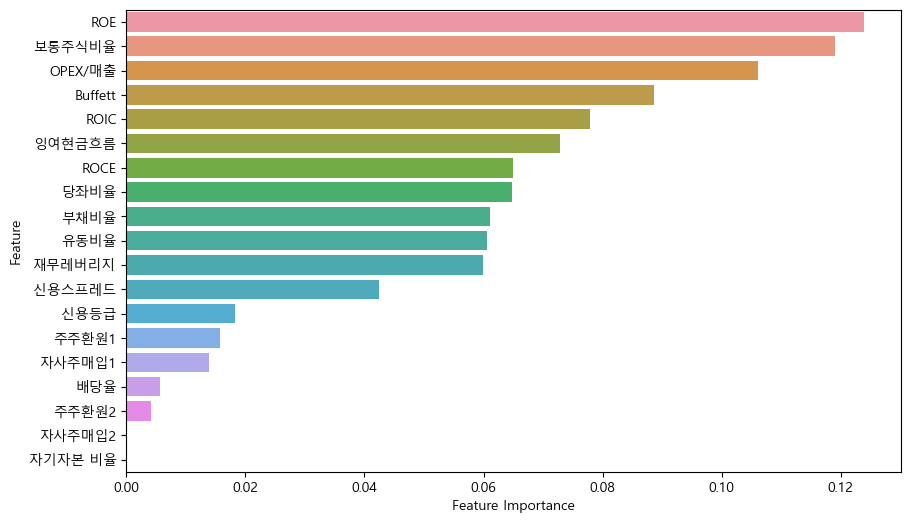

0.02247191011235955


In [19]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'


# 예시 데이터 로드

X = x_tr
y = y_tr

# Random Forest 모델 생성
model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
model.fit(X, y)

# 변수 중요도 확인
feature_importances = model.feature_importances_

# 중요도를 기준으로 내림차순 정렬
indices = np.argsort(feature_importances)[::-1]

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=feature_importances[indices], y=X.columns[indices]) ## 정확한 수치는 feature_importances[0]으로 뽑아내기 가능함
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

pred=model.predict(x_test)
print(precision_score(y_test,pred))


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
#내 생각으로는 precision(정밀도)가 정확한 평가방법일거라고 생각. 예상치중 얼마나 잘 맞는가가 중요하므로. 

alphas=[0.001,0.01,0.1,1,10]
grid=GridSearchCV
param_grid = {'penalty':['l1','l2','elasticnet'],'C': [0.001, 0.01, 0.1, 1, 10, 100]} #주의. 알파값 역수임. 0.001이면 규제가 쌘거

# Logistic Regression 모델 생성
logR1= LogisticRegression(solver='liblinear')  #l1,l2 동시 사용가능한거 liblinear혼자, 3개 다 가능한건 saga
logR2= LogisticRegression(solver='lbfgs') #그나마 학습값 높게나오는거 요거
logR3= LogisticRegression(solver='saga')

grid = GridSearchCV(logR1, param_grid, cv=5, scoring='precision') #5번 반복이고, 정밀도로 평가
grid2 = GridSearchCV(logR2, param_grid, cv=5, scoring='precision') #5번 반복이고, 정밀도로 평가
grid3 = GridSearchCV(logR3, param_grid, cv=5, scoring='precision') #5번 반복이고, 정밀도로 평가

# 그리드 서치 수행
grid.fit(x_tr, y_tr)
grid2.fit(x_tr, y_tr)
grid3.fit(x_tr, y_tr)

# 최적의 하이퍼파라미터 및 정밀도 출력
print("Best Hyperparameters:", grid.best_params_)
print("Best Precision:", grid.best_score_)

print("Best Hyperparameters:", grid2.best_params_)
print("Best Precision:", grid2.best_score_)

print("Best Hyperparameters:", grid3.best_params_)
print("Best Precision:", grid3.best_score_)


# 최적의 모델 얻기
best_model1 = grid.best_estimator_
best_model2 = grid2.best_estimator_
best_model3 = grid3.best_estimator_

pred_l1=best_model.predict(x_test)
print(precision_score(y_test,pred_l1))

pred_l2=best_model2.predict(x_test)
print(precision_score(y_test,pred_l2))

pred_l3=best_model3.predict(x_test)
print(precision_score(y_test,pred_l3))


# # 회귀 계수 출력
# coefficients = best_model.coef_
# print("Coefficients:", coefficients)

# coefficients2 = best_model2.coef_
# print("Coefficients:", coefficients2)

Best Hyperparameters: {'C': 0.1, 'penalty': 'l2'}
Best Precision: 0.5705645161290323
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2'}
Best Precision: 0.6633797653958944
Best Hyperparameters: {'C': 0.01, 'penalty': 'l2'}
Best Precision: 0.4
0.08163265306122448
0.08163265306122448
0.0


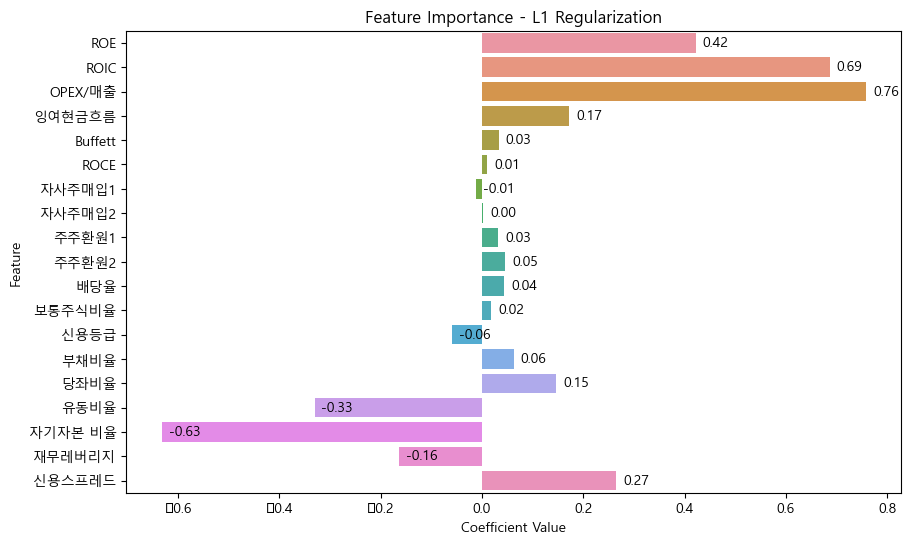

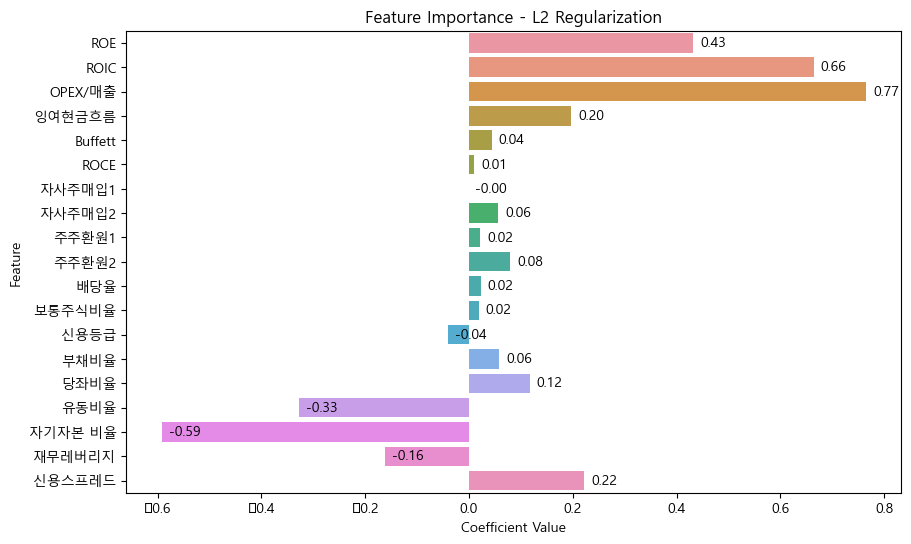

In [39]:
import pandas as pd
import matplotlib.pyplot as plt


# Assuming x_tr is your feature matrix and best_model is the best logistic regression model
coefficients = best_model.coef_[0]

# Ensure that coefficients is 1-dimensional
coefficients = coefficients.flatten()

# Create a DataFrame for L1 regularization coefficients
l1_param = pd.DataFrame({'Feature': x_tr.columns, 'Coefficient': coefficients})

# Plotting the bar plot for L1 regularization
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Coefficient', y='Feature', data=l1_param)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance - L1 Regularization")

# 숫자를 막대 위에 표시하는 코드
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}', (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.show()

# Assuming x_tr is your feature matrix and best_model2 is the best logistic regression model with L2 regularization
coefficients2 = best_model2.coef_[0]

# Ensure that coefficients2 is 1-dimensional
coefficients2 = coefficients2.flatten()

# Create a DataFrame for L2 regularization coefficients
l2_param = pd.DataFrame({'Feature': x_tr.columns, 'Coefficient2': coefficients2})

# Plotting the bar plot for L2 regularization
plt.figure(figsize=(10, 6))
ax2 = sns.barplot(x='Coefficient2', y='Feature', data=l2_param)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance - L2 Regularization")

# 숫자를 막대 위에 표시하는 코드
for p in ax2.patches:
    ax2.annotate(f'{p.get_width():.2f}', (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                 ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.show()

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# X에는 독립 변수들을 담은 데이터프레임을 넣어주세요
vif_result = calculate_vif(x_tr)
print(vif_result)

# 10 이상이면 변수간 상관성이 높고, 5이상이면 주의. 

   Variable           VIF
0       ROE  1.093202e+00
1      ROIC  1.235610e+00
2   OPEX/매출  2.136449e+00
3    잉여현금흐름  2.928744e+00
4   Buffett  2.962030e+00
5      ROCE  1.002003e+00
6    자사주매입1           inf
7    자사주매입2           inf
8     주주환원1           inf
9     주주환원2           inf
10      배당율           inf
11   보통주식비율  8.390089e+00
12     신용등급  5.545738e+01
13     부채비율           inf
14     당좌비율  2.607154e+00
15     유동비율  1.998635e+00
16  자기자본 비율  1.801440e+15
17   재무레버리지           inf
18   신용스프레드  7.203320e+00
